# Import thư viện

In [3]:
# Thư viện cơ bản
import numpy as np
import pandas as pd

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns   

# Thư viện tiền xử lý dữ liệu, tối ưu hóa mô hình
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer

# Thư viện xây dựng mô hình
from sklearn.neighbors import KNeighborsClassifier

# Thư viện đánh giá mô hình
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, make_scorer, recall_score, ConfusionMatrixDisplay, precision_score

df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
df['Potability'].value_counts()
# 0 - Không uống được
# 1 - Uống được

Potability
0    1998
1    1278
Name: count, dtype: int64

# Tiền xử lý dữ liệu

In [6]:
df.isnull().sum()[df.isnull().sum() > 0] / len(df) * 100

ph                 14.987790
Sulfate            23.840049
Trihalomethanes     4.945055
dtype: float64

In [7]:
df[df['Potability'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1684.0,7.085378,1.683499,0.000000,6.037723,7.035456,8.155510,14.000000
Hardness,1998.0,196.733292,31.057540,98.452931,177.823265,197.123423,216.120687,304.235912
Solids,1998.0,21777.490788,8543.068788,320.942611,15663.057382,20809.618280,27006.249009,61227.196008
Chloramines,1998.0,7.092175,1.501045,1.683993,6.155640,7.090334,8.066462,12.653362
Sulfate,1510.0,334.564290,36.745549,203.444521,311.264006,333.389426,356.853897,460.107069
Conductivity,1998.0,426.730454,80.047317,181.483754,368.498530,422.229331,480.677198,753.342620
Organic_carbon,1998.0,14.364335,3.334554,4.371899,12.101057,14.293508,16.649485,28.300000
Trihalomethanes,1891.0,66.303555,16.079320,0.738000,55.706530,66.542198,77.277704,120.030077
Turbidity,1998.0,3.965800,0.780282,1.450000,3.444062,3.948076,4.496106,6.739000
Potability,1998.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df[df['Potability'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1101.0,7.073783,1.448048,0.227499,6.179312,7.036752,7.933068,13.175402
Hardness,1278.0,195.800744,35.547041,47.432000,174.330531,196.632907,218.003420,323.124000
Solids,1278.0,22383.991018,9101.010208,728.750830,15668.985035,21199.386614,27973.236446,56488.672413
Chloramines,1278.0,7.169338,1.702988,0.352000,6.094134,7.215163,8.199261,13.127000
Sulfate,985.0,332.566990,47.692818,129.000000,300.763772,331.838167,365.941346,481.030642
Conductivity,1278.0,425.383800,82.048446,201.619737,360.939023,420.712729,484.155911,695.369528
Organic_carbon,1278.0,14.160893,3.263907,2.200000,12.033897,14.162809,16.356245,23.604298
Trihalomethanes,1223.0,66.539684,16.327419,8.175876,56.014249,66.678214,77.380975,124.000000
Turbidity,1278.0,3.968328,0.780842,1.492207,3.430909,3.958576,4.509569,6.494249
Potability,1278.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Xem trung bình, trung vị của 3 cột có giá trị null
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].mean()) 
print('\n')
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].median())

ph                   7.085378
Sulfate            334.564290
Trihalomethanes     66.303555
dtype: float64


ph                   7.035456
Sulfate            333.389426
Trihalomethanes     66.542198
dtype: float64


In [10]:
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].mean()
print('\n')
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].median()

ph                   7.036752
Sulfate            331.838167
Trihalomethanes     66.678214
dtype: float64

In [11]:
for cols in df.columns:
    iqr = df[cols].quantile(0.75) - df[cols].quantile(0.25)
    lower_bound = df[cols].quantile(0.25) - (1.5 * iqr)
    upper_bound = df[cols].quantile(0.75) + (1.5 * iqr)
    df[cols] = np.where(df[cols] > upper_bound, upper_bound, df[cols])
    df[cols] = np.where(df[cols] < lower_bound, lower_bound, df[cols])

# Chia train test


In [12]:
X = df.drop('Potability',axis=1)
y = df['Potability']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Điền null

In [14]:
X_train_filled = X_train.copy()
X_test_filled = X_test.copy()

# Fill cho từng nhãn 0 và 1
for label_value in [0, 1]:
    # Lấy chỉ số nhóm theo nhãn
    group_train_idx = y_train[y_train == label_value].index
    group_train = X_train.loc[group_train_idx]

    # Fit + transform toàn bộ cột
    imputer = KNNImputer(n_neighbors=5)
    imputed = imputer.fit_transform(group_train)
    X_train_filled.loc[group_train_idx] = pd.DataFrame(
        imputed, columns=X_train.columns, index=group_train_idx
    )

# Dùng nhóm train đã fit để fill cho test
for label_value in [0, 1]:
    # Tách nhóm train theo nhãn
    group_train_idx = y_train[y_train == label_value].index
    group_train = X_train.loc[group_train_idx]

    # Tách nhóm test theo nhãn
    group_test_idx = y_test[y_test == label_value].index
    group_test = X_test.loc[group_test_idx]

    # Fit trên train + transform test
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(group_train)
    imputed = imputer.transform(group_test)

    X_test_filled.loc[group_test_idx] = pd.DataFrame(
        imputed, columns=X_test.columns, index=group_test_idx
    )

In [15]:
print(X_train_filled.isnull().sum()[X_train_filled.isnull().sum() > 0])
print(X_test_filled.isnull().sum()[X_test_filled.isnull().sum() > 0])

Series([], dtype: int64)
Series([], dtype: int64)


## Chuẩn hóa

In [16]:
scaler = StandardScaler()
X_train_filled = scaler.fit_transform(X_train_filled)
X_test_filled = scaler.transform(X_test_filled)

# Chạy mô hình

In [17]:
knn = KNeighborsClassifier()
knn.fit(X_train_filled, y_train)

KNeighborsClassifier()

In [18]:
y_pred = knn.predict(X_test_filled)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72       600
         1.0       0.52      0.36      0.43       383

    accuracy                           0.62       983
   macro avg       0.59      0.57      0.57       983
weighted avg       0.60      0.62      0.60       983



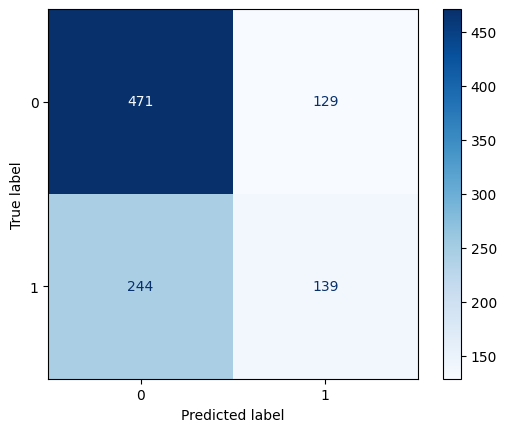

In [20]:
cm = confusion_matrix(y_test, y_pred)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
display_cm.plot(cmap='Blues')

# Tối ưu mô hình

In [21]:
param = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

scoring=make_scorer(precision_score, pos_label=1)

In [22]:
grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param,
    scoring=scoring,
    cv=5,                                                 
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_filled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(precision_score, response_method='predict', pos_label=1),
             verbose=1)

In [23]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

In [24]:
y_proba = grid.predict_proba(X_test_filled)[:, 1]

In [25]:
# Tạo 1 chuỗi threshold (ngưỡng) từ 0.0 đến 1.0, bước nhảy 0.01
threshold = np.arange(0.0, 1.01, 0.01)

# 1 mảng lưu kết quả từ confusion matrix (ma trận nhầm lẫn)
res = []

for t in threshold:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    res.append((t, fp, fn, tp, tn))

In [26]:
df_thresh = pd.DataFrame(res, columns=['Threshold', 'FP', 'FN', 'TP', 'TN'])
df_thresh['Precision'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FP'])
df_thresh['Recall'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FN'])

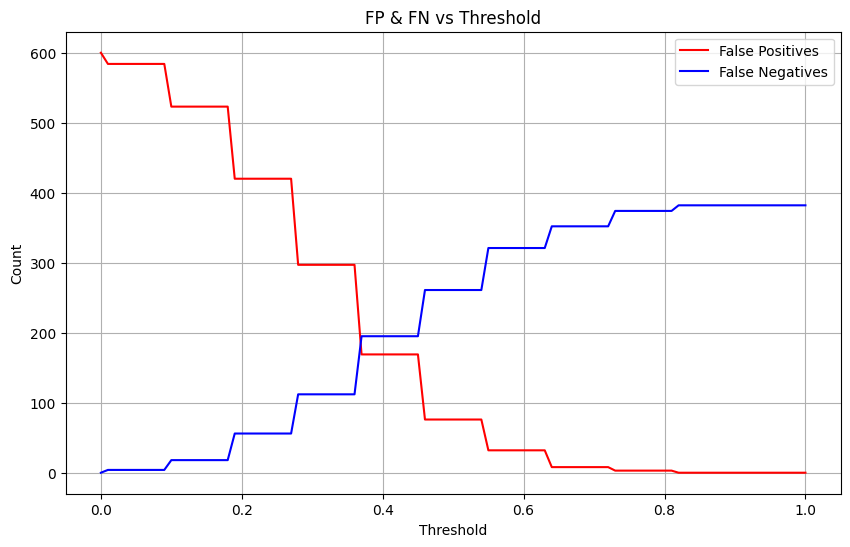

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh["Threshold"], df_thresh["FP"], label="False Positives", color="red")
plt.plot(df_thresh["Threshold"], df_thresh["FN"], label="False Negatives", color="blue")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title("FP & FN vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [28]:
# In ra confusion matrix & classification report theo nhiều threshold khác nhau
for t in threshold:
    print(f"Threshold: {t:.2f}")
    y_pred = (y_proba >= t).astype(int)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Threshold: 0.00
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       600
         1.0       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro avg       0.19      0.50      0.28       983
weighted avg       0.15      0.39      0.22       983

Threshold: 0.01
[[ 16 584]
 [  4 379]]
              precision    recall  f1-score   support

         0.0       0.80      0.03      0.05       600
         1.0       0.39      0.99      0.56       383

    accuracy                           0.40       983
   macro avg       0.60      0.51      0.31       983
weighted avg       0.64      0.40      0.25       983

Threshold: 0.02
[[ 16 584]
 [  4 379]]
              precision    recall  f1-score   support

         0.0       0.80      0.03      0.05       600
         1.0       0.39      0.99      0.56       383

    accuracy                           0.40       983
   macro av

In [29]:
y_pred_best = (y_proba >= 0.55).astype(int)

In [30]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

         0.0       0.64      0.95      0.76       600
         1.0       0.66      0.16      0.26       383

    accuracy                           0.64       983
   macro avg       0.65      0.55      0.51       983
weighted avg       0.65      0.64      0.57       983



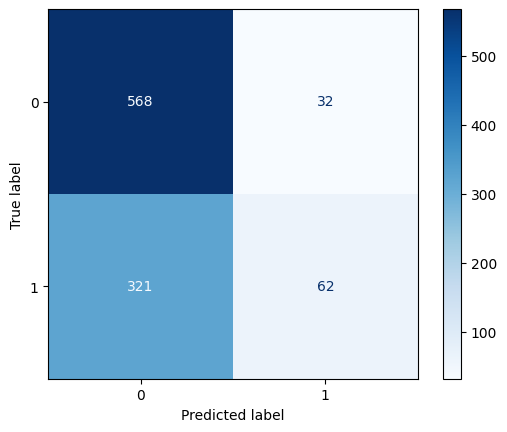

In [31]:
cm_best = confusion_matrix(y_test, y_pred_best)
display_cm_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
display_cm_best.plot(cmap='Blues')

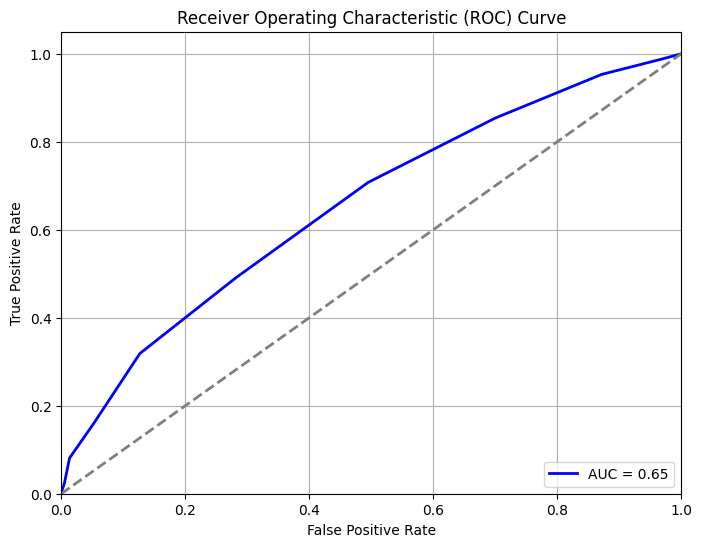

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()